In [1]:
import pandas as pd
import numpy as np
import pickle
from torch.utils.data import Dataset, DataLoader
import torch 
import torch.nn as nn 
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
with open("./BERT_data/non_offensive_text.pkl", "rb") as f:
    non_off_txt= pickle.load(f)
    
with open("./BERT_data/offensive_text.pkl", "rb") as f:
    off_txt= pickle.load(f)
    
with open("./BERT_data/non_offensive_desc.pkl", "rb") as f:
    non_off_desc= pickle.load(f)
    
with open("./BERT_data/offensive_desc.pkl", "rb") as f:
    off_desc= pickle.load(f)
    
with open("./BERT_data/non_text_test.pkl", "rb") as f:
    non_off_txt_test= pickle.load(f)
    
with open("./BERT_data/off_text_test.pkl", "rb") as f:
    off_txt_test= pickle.load(f)
    
with open("./BERT_data/non_desc_test.pkl", "rb") as f:
    non_off_desc_test= pickle.load(f)
    
with open("./BERT_data/off_desc_test.pkl", "rb") as f:
    off_desc_test= pickle.load(f)

In [3]:
for i in range(len(non_off_txt)):
    non_off_txt[i]= non_off_txt[i].detach().numpy() 
    off_txt[i]= off_txt[i].detach().numpy() 
    non_off_desc[i]=non_off_desc[i].detach().numpy() 
    off_desc[i]= off_desc[i].detach().numpy() 
    
for i in range(len(non_off_txt_test)):
    non_off_txt_test[i]= non_off_txt_test[i].detach().numpy() 
    off_txt_test[i]= off_txt_test[i].detach().numpy() 
    non_off_desc_test[i]=non_off_desc_test[i].detach().numpy() 
    off_desc_test[i]=off_desc_test[i].detach().numpy() 

In [4]:
non_off_txt= np.array(non_off_txt)
off_txt= np.array(off_txt)
non_off_desc=np.array(non_off_desc)
off_desc=np.array(off_desc)
stacked_array = np.vstack([non_off_txt, off_txt])
stacked_array2 = np.vstack([non_off_desc, off_desc])
final_train = np.concatenate([stacked_array.reshape(2000, 1, -1), stacked_array2.reshape(2000, 1, -1)], axis=2)

non_off_txt_test= np.array(non_off_txt_test)
off_txt_test= np.array(off_txt_test)
non_off_desc_test= np.array(non_off_desc_test)
off_desc_test= np.array(off_desc_test) 
stacked_array_test = np.vstack([non_off_txt_test, off_txt_test])
stacked_array_test2 = np.vstack([non_off_desc_test, off_desc_test])
final_test = np.concatenate([stacked_array_test.reshape(500, 1, -1), stacked_array_test2.reshape(500, 1, -1)], axis=2)
print(final_test.shape)

(500, 1, 1536)


In [5]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.labels[idx]}
        return sample

In [6]:
data = [] 
labels = [0] * len(non_off_txt)+[1]*len(off_txt)
labels_test = [0] * len(non_off_txt_test)+[1]*len(off_txt_test)
dataset = MyDataset(final_train, labels)
dataset_test = MyDataset(final_test, labels_test)

In [7]:
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [8]:
torch.manual_seed(43)
np.random.seed(43)

class RNNmodel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.5):
        super(RNNmodel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers= num_layers
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim) 
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        out, _ = self.rnn(x, hidden)
        out = out[:, -1, :]
        out = self.fc(out)
        return out
    
model = RNNmodel(1536, 128, 2, 2)
lr= 1e-4
num_epoch= 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [9]:
train_loss=[]
test_loss=[]

for epoch in range(1, num_epoch+1):
    total_loss = 0
    for batch in train_loader:
        X= batch["data"]
        y= batch["label"]
        optimizer.zero_grad() 
        X = X.float()
        output = model(X)
        loss = criterion(output, y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()    
    total_loss /= len(train_loader)
        
    total_test_loss=0
    with torch.no_grad():  # Disable gradient calculation during testing
        for batch in test_loader:
            X_test = batch["data"]
            y_test = batch["label"]
            X_test = X_test.float()
            output_test = model(X_test)
            loss_test = criterion(output_test, y_test)
            total_test_loss += loss_test.item()
    total_test_loss /= len(test_loader)
    
    train_loss.append(total_loss)
    test_loss.append(total_test_loss)
    
    # Print training and testing loss
    print('Epoch: {}/{} - Train Loss: {:.4f} - Test Loss: {:.4f}'.format(epoch, num_epoch, total_loss, total_test_loss))



Epoch: 1/50 - Train Loss: 0.7086 - Test Loss: 0.7138
Epoch: 2/50 - Train Loss: 0.7043 - Test Loss: 0.7081
Epoch: 3/50 - Train Loss: 0.7012 - Test Loss: 0.7057
Epoch: 4/50 - Train Loss: 0.6987 - Test Loss: 0.7027
Epoch: 5/50 - Train Loss: 0.6968 - Test Loss: 0.7008
Epoch: 6/50 - Train Loss: 0.6951 - Test Loss: 0.6997
Epoch: 7/50 - Train Loss: 0.6934 - Test Loss: 0.6979
Epoch: 8/50 - Train Loss: 0.6928 - Test Loss: 0.6977
Epoch: 9/50 - Train Loss: 0.6919 - Test Loss: 0.6972
Epoch: 10/50 - Train Loss: 0.6913 - Test Loss: 0.6969
Epoch: 11/50 - Train Loss: 0.6910 - Test Loss: 0.6967
Epoch: 12/50 - Train Loss: 0.6905 - Test Loss: 0.6960
Epoch: 13/50 - Train Loss: 0.6897 - Test Loss: 0.6960
Epoch: 14/50 - Train Loss: 0.6895 - Test Loss: 0.6952
Epoch: 15/50 - Train Loss: 0.6894 - Test Loss: 0.6946
Epoch: 16/50 - Train Loss: 0.6889 - Test Loss: 0.6956
Epoch: 17/50 - Train Loss: 0.6887 - Test Loss: 0.6951
Epoch: 18/50 - Train Loss: 0.6885 - Test Loss: 0.6950
Epoch: 19/50 - Train Loss: 0.6881 - T

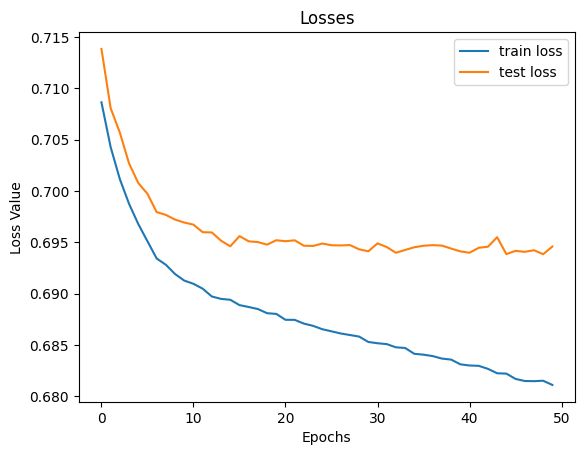

In [10]:
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(test_loss)), test_loss, label="test loss")
plt.legend()
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.show()

In [11]:
y_pred= model(torch.tensor(final_test).float())

In [12]:
print(metrics.precision_score((torch.max(y_pred, dim=1)[1]).detach().numpy(), labels_test),
metrics.recall_score((torch.max(y_pred, dim=1)[1]).detach().numpy(), labels_test),
metrics.roc_auc_score((torch.max(y_pred, dim=1)[1]).detach().numpy(), labels_test),
metrics.accuracy_score((torch.max(y_pred, dim=1)[1]).detach().numpy(), labels_test))

0.648 0.5175718849840255 0.5234918248449539 0.522


In conclusion, we observe:
1. Using BERT embeddings for sentences would be better in larger scale projects because it would enable sentence embeddings in lesser dimensions. We will not need a huge vocabulary for representation purposes. Pretrained BERT will also help in understanding more semantic embeddings of the text.
2. This model- which uses a concatenation of original caption along with a generated description, is able to give a good balance of precision and recall- something that was missing in other models, but has an average AUROC and accuracy score. 
3. Potential scope of improvement would be to generate image text similarity of the image with the original caption and the generated description and accordingly scale the embeddings. Must be explored if possible.
4. Seed 43 seems to give good results with the graphing, but most other seeds follow the same pattern- both descreasing with epochs for SGD, with lr set to 1e-4. 